# ПРОЕКТ: Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Инструкция по выполнению проекта**

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. 
Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

**Описание данных**

**Признаки:**
- `DateCrawled` — дата скачивания анкеты из базы;
- `VehicleType` — тип автомобильного кузова;
- `RegistrationYear` — год регистрации автомобиля;
- `Gearbox` — тип коробки передач;
- `Power` — мощность (л. с.);
- `Model` — модель автомобиля;
- `Kilometer` — пробег (км);
- `RegistrationMonth` — месяц регистрации автомобиля;
- `FuelType` — тип топлива;
- `Brand` — марка автомобиля;
- `Repaired` — была машина в ремонте или нет;
- `DateCreated` — дата создания анкеты;
- `NumberOfPictures` — количество фотографий автомобиля;
- `PostalCode` — почтовый индекс владельца анкеты (пользователя);
- `LastSeen` — дата последней активности пользователя.

**Целевой признак:**
- `Price` — цена (евро).

## Подготовка данных

### Формирование ProfileReport

Для проведения анализа и подготовки данных воспользуемся ProfileReport из библиотеки ydata_profiling

In [6]:
!pip install ydata_profiling

In [7]:
pip install --upgrade pillow

Note: you may need to restart the kernel to use updated packages.


Для оценки корреляции между различными типами данных воспользуемся коэффициентом корреляции $\phi_K$

In [9]:
!pip install phik

Для корректной работы OneHotEncoder установим версию 1.1.3 библиотеки scikit-learn

In [11]:
!pip install scikit-learn==1.1.3

  Using cached scikit-learn-1.1.3.tar.gz (7.0 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
          backend = _build_backend()
                    ^^^^^^^^^^^^^^^^
        File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_backend
          obj = import_m

In [12]:
!pip install lightgbm

In [13]:
!pip install catboost

In [14]:
pip install -U ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install ipympl

In [16]:
# импорты сторонних библиотек
import pandas as pd
import numpy as np

import matplotlib
%matplotlib ipympl
import matplotlib.pyplot as plt

import seaborn as sns

# импорты модулей текущего проекта
from ydata_profiling import ProfileReport

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# константы
RANDOM_STATE = 12345

# отображение выводимых таблиц
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [17]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [18]:
profile = ProfileReport(df, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Удаление полных дубликатов

In [20]:
df1 = df.copy() #копия для дальнейшего использования

In [21]:
df = df.drop_duplicates()
print(f'Осталось строк: {df.shape[0]}')

Осталось строк: 354365


### Выбор важных признаков. Удаление столбцов, не влияющих на целевой признак

In [23]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

**Важные признаки,** влияющие на цену, расположим в общепринятом/логичном порядке:
- общие данные: `Brand`, `Model`, `VehicleType`, `RegistrationYear`; 
- двигатель и коробка: `Power`, `FuelType`, `Gearbox`; 
- эксплуатация: `Kilometer`, `Repaired`.

Столбец `DateCrawled` содержит даты скачивания анкет с марта по апрель 2016 года. Данная информация не влияет на целевой признак стоимость автомобиля.

Столбец `RegistrationMonth` содержит месяц регистрации автомобиля - не влияет на цену автомобиля, так как основной фактор для цены - это год выпуска авто (в нашем случае отсутствует, вместо него - год регистрации).

Столбец `DateCreated` содержит даты создания анкет - не влияет на цену автомобиля. Влияет на оценку скорости продажи, но это не наш целевой признак.

Столбец `NumberOfPictures` - константа, содержит только нули. Возможно, это ошибка при формировании датасета. В таком виде столбец не может влиять на целевой признак.

Столбцы `PostalCode`, `LastSeen` относятся к пользователю, а не автомобилю. Соответственно, не влияют на целевой признак.

**Удаляем 6 столбцов:** 

In [26]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
print(f'Осталось столбцов: {df.shape[1]}')

Осталось столбцов: 10


Расположим оставшиеся в таблице столбцы в логичном для анализа порядке:

In [28]:
df = df[['Price', 'Brand', 'Model', 'VehicleType', 'RegistrationYear', 'Power', 'FuelType', 'Gearbox', 'Kilometer', 'Repaired']]
df.columns

Index(['Price', 'Brand', 'Model', 'VehicleType', 'RegistrationYear', 'Power',
       'FuelType', 'Gearbox', 'Kilometer', 'Repaired'],
      dtype='object')

### Анализ и подготовка столбцов с целевым и важными признаками

1.4.1 Целевой признак `Price` содержит 3% нулевых значений, что является аномалией. Еще 0.7% авто с ценой меньше 100, что также неправдоподобно. Возможно, это ошибки, возникшие при формировании базы данных, может пользовательская ошибка при вводе объявления / ошибка в размерности. Доля строк с сомнительной ценой незначительная (3.8%), удалим их. 

In [31]:
print(f'Доля аномалий: {df.query("Price < 100")["Price"].count() / df.shape[0]:0.2%}')

Доля аномалий: 3.76%


In [32]:
print(f'Строк к удалению: {df.query("Price < 100")["Price"].count()}')
df = df.query('Price >= 100')
print(f'Строк осталось:  {df.shape[0]}')

Строк к удалению: 13314
Строк осталось:  341051


1.4.2 Столбец `Brand` категорийного типа содержит 40 уникальных категорий, без пропусков. 

In [34]:
df['Brand'].value_counts()

Brand
volkswagen        73932
opel              38178
bmw               35556
mercedes_benz     31195
audi              28415
ford              24207
renault           17238
peugeot           10706
fiat               9262
seat               6682
mazda              5439
skoda              5422
smart              5149
citroen            4984
nissan             4776
toyota             4525
hyundai            3517
mini               3159
volvo              3106
mitsubishi         2907
honda              2702
sonstige_autos     2700
kia                2397
suzuki             2256
alfa_romeo         2211
chevrolet          1697
chrysler           1354
dacia               888
daihatsu            761
subaru              722
porsche             705
jeep                652
land_rover          533
daewoo              528
saab                512
jaguar              486
trabant             475
rover               456
lancia              449
lada                212
Name: count, dtype: int64

1.4.3 Текстовый столбец `Model` содержит 250 моделей авто, также 5.6% пропусков.
Посмотрим на ошибки в названиях:

In [36]:
sorted(df['Model'].unique().astype('str'))

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [37]:
df['Model'] = df['Model'].replace('rangerover', 'range_rover')

6 уникальных значений встречаются менее 10 раз, что для выборки из 350 тыс. объектов очень мало. Включим их и пропуски в категорию 'other'.

In [39]:
df['Model'].value_counts()

Model
golf                  28086
other                 23499
3er                   19074
polo                  12511
corsa                 12039
astra                 10406
passat                 9792
a4                     9599
c_klasse               8158
5er                    7614
e_klasse               6594
a3                     6009
focus                  5724
fiesta                 5586
a6                     5348
twingo                 4758
2_reihe                4749
transporter            4648
fortwo                 4280
a_klasse               4113
vectra                 4064
1er                    3492
mondeo                 3456
clio                   3436
touran                 3419
3_reihe                3403
punto                  3221
zafira                 2979
megane                 2783
ibiza                  2627
ka                     2573
lupo                   2528
octavia                2089
fabia                  2059
cooper                 1931
clk           

In [40]:
rare = df['Model'].value_counts()[df['Model'].value_counts() < 10]
df['Model'] = df['Model'].replace(rare.index.values, 'other')

In [41]:
df['Model'] = df['Model'].fillna('other')
print(f'Стало категорий: {df["Model"].nunique()}')

Стало категорий: 243


1.4.4 Столбец `VehicleType` категорийного типа (8 разных категорий), имеет 10.6% пропущенных значений. Возможно, причина пропусков - это заполнение пользователями не всех полей анкеты. Заполнение возможно, но потребует ручной труд, большие временные затраты. Появление в будущих анкетах таких же пропусков не исключено. Введем еще одну категорию - заполним все пропуски значением 'unknown':

In [43]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['VehicleType'].isna().sum()

0

1.4.5 В числовом столбце `RegistrationYear` аномальные цифры - это значения меньше 1901 (год начала регистрации авто в Нью-Йорке, в России регистрация автомобилей началась с 1904 года) и больше 2016 (год скачивания анкет из базы 2016). Доля ошибок - 4%. Заполним ошибки медианным значением:

In [45]:
n = df.query('(RegistrationYear > 2016) | (RegistrationYear < 1901)')['RegistrationYear'].count()
print(f'Аномалии: {n}, {round(n / df.shape[0], 2):0.2%}')

Аномалии: 13730, 4.00%


In [46]:
print(f'Было ячеек со значением 2003: {df.query("RegistrationYear == 2003")["RegistrationYear"].count()}')
df.loc[(df['RegistrationYear'] > 2016) | (df['RegistrationYear'] < 1901), 'RegistrationYear'] = 2003
print(f'Стало: {df.query("RegistrationYear == 2003")["RegistrationYear"].count()}')

Было ячеек со значением 2003: 19452
Стало: 33182


1.4.6 Числовой столбец `Power` содержит 10.3% нулевых значений, что является аномалией. Возможно, это ошибки, возникшие при формировании базы данных, может пользовательская ошибка при вводе объявления.

In [48]:
print(f'Доля аномалий с учетом ранее удаленных строк: {df.query("Power == 0")["Power"].count() / df.shape[0]:0.2%}')

Доля аномалий с учетом ранее удаленных строк: 10.28%


In [49]:
print('Всего машин:', df1.query("Model == 'vectra'")['Price'].count())
print('Всего машин с нулевой мощностью:', df1.query("(Model == 'vectra') & (Power == 0)")['Price'].count())
print('Медианная цена:', df1.query("Model == 'vectra'")['Price'].median())
df1.query("(Model == 'vectra') & (Power == 0)")['Price'].value_counts()

Всего машин: 4254
Всего машин с нулевой мощностью: 520
Медианная цена: 1100.0


Price
0        41
800      26
650      22
500      22
450      18
150      15
999      15
200      14
350      14
900      14
250      12
1500     12
1100     11
300      11
600      11
1200     10
1000     10
1250      9
950       8
400       8
850       8
550       7
700       6
1750      6
1150      6
750       6
1300      5
2200      5
3000      5
1650      4
1400      4
100       4
2500      4
2400      4
3500      4
1800      4
1900      4
1         3
3200      3
220       3
690       3
3300      3
2800      3
1450      3
599       3
399       3
499       3
699       3
380       3
2000      3
1999      3
50        2
1499      2
1199      2
5350      2
2750      2
1700      2
2990      2
2450      2
120       2
899       2
2999      2
2199      2
3800      2
2950      2
2100      2
1350      2
330       1
7600      1
3999      1
255       1
390       1
1600      1
180       1
210       1
5500      1
1299      1
1390      1
80        1
299       1
12345     1
2599      1
2900      

Также, с учетом анализа названий моделей, вызывает недоверие мощность автомобилей более 500 лс:

In [51]:
print(f'доля авто с мощьностью более 500 лс: {df.query("Power > 500")["Model"].value_counts().sum() / df.shape[0]:0.2%}')
df.query("Power > 500")['Model'].value_counts()

доля авто с мощьностью более 500 лс: 0.12%


Model
other          83
golf           22
polo           16
3er            15
corsa          15
astra          13
e_klasse       13
passat         12
vectra         12
m_reihe        10
5er             9
transporter     9
twingo          7
a4              7
c_klasse        7
focus           7
a6              6
zafira          6
cayenne         6
s_klasse        5
a_klasse        5
scenic          4
fiesta          4
matiz           4
berlingo        4
a3              4
a8              3
fortwo          3
galaxy          3
80              3
micra           3
lupo            3
clk             3
cooper          3
laguna          3
ka              3
kangoo          3
500             3
mondeo          3
s_type          3
3_reihe         3
punto           3
m_klasse        2
touran          2
agila           2
octavia         2
civic           2
stilo           2
1er             2
toledo          2
v40             2
ypsilon         2
arosa           2
c4              2
c2              2
clio

Заполним аномальные значения медианным значением мощности модели (без учета нулевых и значений больше 500):

In [53]:
df.query('Model == "100"') # проверка - до

Price Brand Model  VehicleType  RegistrationYear  Power  FuelType  \
145       150  audi   100      unknown              1985      0    petrol   
1482      450  audi   100        wagon              1994      0    petrol   
1598     1100  audi   100        sedan              1992    150    petrol   
1767     6450  audi   100        wagon              1992    230    petrol   
2054      650  audi   100        wagon              1990     90    petrol   
3137     1399  audi   100        sedan              1993    150    petrol   
4703     1550  audi   100        sedan              1994    150    petrol   
4887     1600  audi   100        wagon              1996    140  gasoline   
5516     1984  audi   100        sedan              1984      0    petrol   
9086     1199  audi   100      unknown              2003    133       NaN   
9760     2500  audi   100        sedan              1991    101    petrol   
10393    1499  audi   100        sedan              1993    150    petrol   
13184    1790  audi   100        sedan              1993    174    petrol   
14220    1111  audi   100        sedan              1991    175       lpg   
16710    1499  audi   100        sedan              1993    150    petrol   
17043     500  audi   100        wagon              1994    116    petrol   
18664    1049  audi   100        sedan              1991    134    petrol   
18921     399  audi   100      unknown              2016    136       NaN   
19297     300  audi   100        sedan              1991    180    petrol   
19431    3250  audi   100        sedan              1987    136    petrol   
19645     700  audi   100        sedan              1991      0       NaN   
20453    8990  audi   100        sedan              1973     86    petrol   
21333    4100  audi   100        sedan              1982     86    petrol   
22902    2500  audi   100        sedan              1991      0    petrol   
23807    4500  audi   100      unknown              1995    230       NaN   
25305    1800  audi   100        sedan              1991    174    petrol   
27556     870  audi   100        sedan              1993    174    petrol   
27881    1150  audi   100        wagon              1997    125    petrol   
29707     800  audi   100        wagon              1998    174    petrol   
30112    1000  audi   100        sedan              1991    133    petrol   
30807    2400  audi   100        sedan              1991    133       NaN   
30834     400  audi   100        sedan              1988    136    petrol   
32200     990  audi   100        sedan              1991     98    petrol   
32641    5500  audi   100        sedan              1988    140    petrol   
33428     550  audi   100        sedan              1991    133    petrol   
33900     580  audi   100        wagon              1992    133    petrol   
35060     850  audi   100        sedan              1979     69  gasoline   
37498     100  audi   100      unknown              1995      0       NaN   
38562    2000  audi   100        wagon              1989    115    petrol   
42408    2000  audi   100        sedan              1991    174    petrol   
42607    2500  audi   100        wagon              1993    150    petrol   
43821    1050  audi   100        sedan              1991    133    petrol   
44245    2000  audi   100        sedan              1983    101    petrol   
44660    1049  audi   100        sedan              1991    134    petrol   
45724    3050  audi   100        wagon              1991    136    petrol   
45854     300  audi   100        sedan              1990    133    petrol   
47915    7500  audi   100        wagon              1993    230    petrol   
48205     550  audi   100        wagon              1992    150    petrol   
49417     950  audi   100        sedan              1991    136    petrol   
54125    1300  audi   100        sedan              1990    136    petrol   
54991    2700  audi   100        wagon              1989    116    petrol   
5544

In [54]:
df.loc[(df['Power'] == 0) | (df['Power'] > 500), 'Power'] = np.nan
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))

In [55]:
df.query('Model == "100"') # проверка - после

Price Brand Model  VehicleType  RegistrationYear  Power  FuelType  \
145       150  audi   100      unknown              1985  133.0    petrol   
1482      450  audi   100        wagon              1994  133.0    petrol   
1598     1100  audi   100        sedan              1992  150.0    petrol   
1767     6450  audi   100        wagon              1992  230.0    petrol   
2054      650  audi   100        wagon              1990   90.0    petrol   
3137     1399  audi   100        sedan              1993  150.0    petrol   
4703     1550  audi   100        sedan              1994  150.0    petrol   
4887     1600  audi   100        wagon              1996  140.0  gasoline   
5516     1984  audi   100        sedan              1984  133.0    petrol   
9086     1199  audi   100      unknown              2003  133.0       NaN   
9760     2500  audi   100        sedan              1991  101.0    petrol   
10393    1499  audi   100        sedan              1993  150.0    petrol   
13184    1790  audi   100        sedan              1993  174.0    petrol   
14220    1111  audi   100        sedan              1991  175.0       lpg   
16710    1499  audi   100        sedan              1993  150.0    petrol   
17043     500  audi   100        wagon              1994  116.0    petrol   
18664    1049  audi   100        sedan              1991  134.0    petrol   
18921     399  audi   100      unknown              2016  136.0       NaN   
19297     300  audi   100        sedan              1991  180.0    petrol   
19431    3250  audi   100        sedan              1987  136.0    petrol   
19645     700  audi   100        sedan              1991  133.0       NaN   
20453    8990  audi   100        sedan              1973   86.0    petrol   
21333    4100  audi   100        sedan              1982   86.0    petrol   
22902    2500  audi   100        sedan              1991  133.0    petrol   
23807    4500  audi   100      unknown              1995  230.0       NaN   
25305    1800  audi   100        sedan              1991  174.0    petrol   
27556     870  audi   100        sedan              1993  174.0    petrol   
27881    1150  audi   100        wagon              1997  125.0    petrol   
29707     800  audi   100        wagon              1998  174.0    petrol   
30112    1000  audi   100        sedan              1991  133.0    petrol   
30807    2400  audi   100        sedan              1991  133.0       NaN   
30834     400  audi   100        sedan              1988  136.0    petrol   
32200     990  audi   100        sedan              1991   98.0    petrol   
32641    5500  audi   100        sedan              1988  140.0    petrol   
33428     550  audi   100        sedan              1991  133.0    petrol   
33900     580  audi   100        wagon              1992  133.0    petrol   
35060     850  audi   100        sedan              1979   69.0  gasoline   
37498     100  audi   100      unknown              1995  133.0       NaN   
38562    2000  audi   100        wagon              1989  115.0    petrol   
42408    2000  audi   100        sedan              1991  174.0    petrol   
42607    2500  audi   100        wagon              1993  150.0    petrol   
43821    1050  audi   100        sedan              1991  133.0    petrol   
44245    2000  audi   100        sedan              1983  101.0    petrol   
44660    1049  audi   100        sedan              1991  134.0    petrol   
45724    3050  audi   100        wagon              1991  136.0    petrol   
45854     300  audi   100        sedan              1990  133.0    petrol   
47915    7500  audi   100        wagon              1993  230.0    petrol   
48205     550  audi   100        wagon              1992  150.0    petrol   
49417     950  audi   100        sedan              1991  136.0    petrol   
54125    1300  audi   100        sedan              1990  136.0    petrol   
54991    2700  audi   100        wagon              1989  116.0    petrol   
5544

1.4.7 Столбец `FuelType` категорийного типа (7 категорий), основные - Petrol и Gasoline. На самом деле одно и то же. Эти два слова имеют один и тот же смысл, а разница в них заключается в том, что они используются в разных странах. Petrol используется в Великобритании, Индии и некоторых других местах, в то время как Gasoline или Gas используется в Соединенных Штатах.
Объединим эти категории.

In [57]:
df['FuelType'].value_counts()

FuelType
petrol      209595
gasoline     96936
lpg           5155
cng            549
hybrid         226
other          154
electric        87
Name: count, dtype: int64

In [58]:
df.loc[df['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'
df.query('FuelType == "petrol"')['FuelType'].count()

306531

Столбец `FuelType`имеет 9.3% пропущенных значений. Возможно, причина пропусков - заполнение пользователями не всех полей анкеты. Заполним пропуски наиболее частым значением по модели.

In [60]:
df.query('Model == "100"') # проверка - до

Price Brand Model  VehicleType  RegistrationYear  Power FuelType  \
145       150  audi   100      unknown              1985  133.0   petrol   
1482      450  audi   100        wagon              1994  133.0   petrol   
1598     1100  audi   100        sedan              1992  150.0   petrol   
1767     6450  audi   100        wagon              1992  230.0   petrol   
2054      650  audi   100        wagon              1990   90.0   petrol   
3137     1399  audi   100        sedan              1993  150.0   petrol   
4703     1550  audi   100        sedan              1994  150.0   petrol   
4887     1600  audi   100        wagon              1996  140.0   petrol   
5516     1984  audi   100        sedan              1984  133.0   petrol   
9086     1199  audi   100      unknown              2003  133.0      NaN   
9760     2500  audi   100        sedan              1991  101.0   petrol   
10393    1499  audi   100        sedan              1993  150.0   petrol   
13184    1790  audi   100        sedan              1993  174.0   petrol   
14220    1111  audi   100        sedan              1991  175.0      lpg   
16710    1499  audi   100        sedan              1993  150.0   petrol   
17043     500  audi   100        wagon              1994  116.0   petrol   
18664    1049  audi   100        sedan              1991  134.0   petrol   
18921     399  audi   100      unknown              2016  136.0      NaN   
19297     300  audi   100        sedan              1991  180.0   petrol   
19431    3250  audi   100        sedan              1987  136.0   petrol   
19645     700  audi   100        sedan              1991  133.0      NaN   
20453    8990  audi   100        sedan              1973   86.0   petrol   
21333    4100  audi   100        sedan              1982   86.0   petrol   
22902    2500  audi   100        sedan              1991  133.0   petrol   
23807    4500  audi   100      unknown              1995  230.0      NaN   
25305    1800  audi   100        sedan              1991  174.0   petrol   
27556     870  audi   100        sedan              1993  174.0   petrol   
27881    1150  audi   100        wagon              1997  125.0   petrol   
29707     800  audi   100        wagon              1998  174.0   petrol   
30112    1000  audi   100        sedan              1991  133.0   petrol   
30807    2400  audi   100        sedan              1991  133.0      NaN   
30834     400  audi   100        sedan              1988  136.0   petrol   
32200     990  audi   100        sedan              1991   98.0   petrol   
32641    5500  audi   100        sedan              1988  140.0   petrol   
33428     550  audi   100        sedan              1991  133.0   petrol   
33900     580  audi   100        wagon              1992  133.0   petrol   
35060     850  audi   100        sedan              1979   69.0   petrol   
37498     100  audi   100      unknown              1995  133.0      NaN   
38562    2000  audi   100        wagon              1989  115.0   petrol   
42408    2000  audi   100        sedan              1991  174.0   petrol   
42607    2500  audi   100        wagon              1993  150.0   petrol   
43821    1050  audi   100        sedan              1991  133.0   petrol   
44245    2000  audi   100        sedan              1983  101.0   petrol   
44660    1049  audi   100        sedan              1991  134.0   petrol   
45724    3050  audi   100        wagon              1991  136.0   petrol   
45854     300  audi   100        sedan              1990  133.0   petrol   
47915    7500  audi   100        wagon              1993  230.0   petrol   
48205     550  audi   100        wagon              1992  150.0   petrol   
49417     950  audi   100        sedan              1991  136.0   petrol   
54125    1300  audi   100        sedan              1990  136.0   petrol   
54991    2700  audi   100        wagon              1989  116.0   petrol   
55445    1000  audi   100        sedan              1995

In [61]:
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))

In [62]:
df.query('Model == "100"') # проверка - после

Price Brand Model  VehicleType  RegistrationYear  Power FuelType  \
145       150  audi   100      unknown              1985  133.0   petrol   
1482      450  audi   100        wagon              1994  133.0   petrol   
1598     1100  audi   100        sedan              1992  150.0   petrol   
1767     6450  audi   100        wagon              1992  230.0   petrol   
2054      650  audi   100        wagon              1990   90.0   petrol   
3137     1399  audi   100        sedan              1993  150.0   petrol   
4703     1550  audi   100        sedan              1994  150.0   petrol   
4887     1600  audi   100        wagon              1996  140.0   petrol   
5516     1984  audi   100        sedan              1984  133.0   petrol   
9086     1199  audi   100      unknown              2003  133.0   petrol   
9760     2500  audi   100        sedan              1991  101.0   petrol   
10393    1499  audi   100        sedan              1993  150.0   petrol   
13184    1790  audi   100        sedan              1993  174.0   petrol   
14220    1111  audi   100        sedan              1991  175.0      lpg   
16710    1499  audi   100        sedan              1993  150.0   petrol   
17043     500  audi   100        wagon              1994  116.0   petrol   
18664    1049  audi   100        sedan              1991  134.0   petrol   
18921     399  audi   100      unknown              2016  136.0   petrol   
19297     300  audi   100        sedan              1991  180.0   petrol   
19431    3250  audi   100        sedan              1987  136.0   petrol   
19645     700  audi   100        sedan              1991  133.0   petrol   
20453    8990  audi   100        sedan              1973   86.0   petrol   
21333    4100  audi   100        sedan              1982   86.0   petrol   
22902    2500  audi   100        sedan              1991  133.0   petrol   
23807    4500  audi   100      unknown              1995  230.0   petrol   
25305    1800  audi   100        sedan              1991  174.0   petrol   
27556     870  audi   100        sedan              1993  174.0   petrol   
27881    1150  audi   100        wagon              1997  125.0   petrol   
29707     800  audi   100        wagon              1998  174.0   petrol   
30112    1000  audi   100        sedan              1991  133.0   petrol   
30807    2400  audi   100        sedan              1991  133.0   petrol   
30834     400  audi   100        sedan              1988  136.0   petrol   
32200     990  audi   100        sedan              1991   98.0   petrol   
32641    5500  audi   100        sedan              1988  140.0   petrol   
33428     550  audi   100        sedan              1991  133.0   petrol   
33900     580  audi   100        wagon              1992  133.0   petrol   
35060     850  audi   100        sedan              1979   69.0   petrol   
37498     100  audi   100      unknown              1995  133.0   petrol   
38562    2000  audi   100        wagon              1989  115.0   petrol   
42408    2000  audi   100        sedan              1991  174.0   petrol   
42607    2500  audi   100        wagon              1993  150.0   petrol   
43821    1050  audi   100        sedan              1991  133.0   petrol   
44245    2000  audi   100        sedan              1983  101.0   petrol   
44660    1049  audi   100        sedan              1991  134.0   petrol   
45724    3050  audi   100        wagon              1991  136.0   petrol   
45854     300  audi   100        sedan              1990  133.0   petrol   
47915    7500  audi   100        wagon              1993  230.0   petrol   
48205     550  audi   100        wagon              1992  150.0   petrol   
49417     950  audi   100        sedan              1991  136.0   petrol   
54125    1300  audi   100        sedan              1990  136.0   petrol   
54991    2700  audi   100        wagon              1989  116.0   petrol   
55445    1000  audi   100        sedan              1995

1.4.8 Столбец `Gearbox` категорийного типа (2 категории), имеет 5.6% пропущенных значений. Возможно, причина пропусков - заполнение пользователями не всех полей анкеты. Заполнение затруднительно. Появление в будущих анкетах таких же пропусков не исключено. Введем еще одну категорию - заполним все пропуски значением 'unknown':

In [64]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Gearbox'].isna().sum()

0

1.4.9 Столбец `Kilometer` числовой, но он имеет 13 значений. 67% значений равны 150000, что скорее всего означает пробег более 150000. То есть пробеги автомобилей объединены в интервальные группы.

In [66]:
df['Kilometer'].value_counts()

Kilometer
150000    229001
125000     35621
100000     14335
90000      11370
80000       9868
70000       8466
60000       7357
50000       6139
40000       4848
5000        4839
30000       4311
20000       3795
10000       1101
Name: count, dtype: int64

1.4.10 Столбец `Repaired` булевого типа, имеет 20% пропущенных значений. Возможно, причина пропусков - заполнение пользователями не всех полей анкеты. Заполнение затруднительно, так как столбец мог не заполняться как по причине отсутствия ремонтов, так и желания скрыть информацию об их наличии. Появление в будущих анкетах таких же пропусков не исключено. Заменим True и False на 1 и 0. Введем еще одну категорию - заполним все пропуски значением 'unknown'.

In [68]:
df['Repaired'] = df['Repaired'].fillna('unknown')
df['Repaired'] = df['Repaired'].replace(True, 1).replace(False, 0)
df['Repaired'].unique()

array(['unknown', 'yes', 'no'], dtype=object)

Все столбцы заполнили, пропусков не осталось. Итого типы столбцов:
- категориальный: `Brand`, `Model`, `VehicleType`, `FuelType`, `Gearbox`, `Repaired`;
- числовой: `Price`, `RegistrationYear`, `Power`, `Kilometer`.

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341051 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             341051 non-null  int64  
 1   Brand             341051 non-null  object 
 2   Model             341051 non-null  object 
 3   VehicleType       341051 non-null  object 
 4   RegistrationYear  341051 non-null  int64  
 5   Power             341051 non-null  float64
 6   FuelType          341051 non-null  object 
 7   Gearbox           341051 non-null  object 
 8   Kilometer         341051 non-null  int64  
 9   Repaired          341051 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 28.6+ MB


1.4.11 Корреляции между столбцами

In [72]:
interval_cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

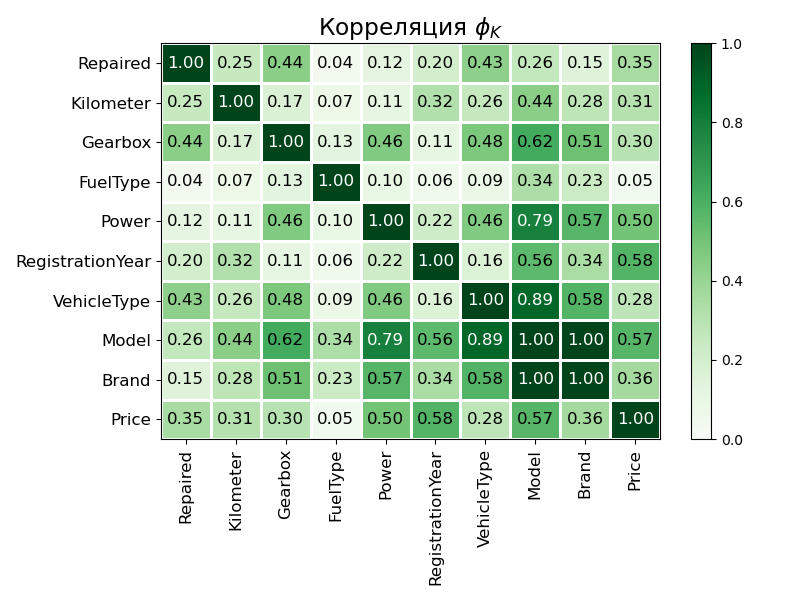

In [211]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1.2, 
                        figsize=(8, 6))
plt.tight_layout()
plt.show()

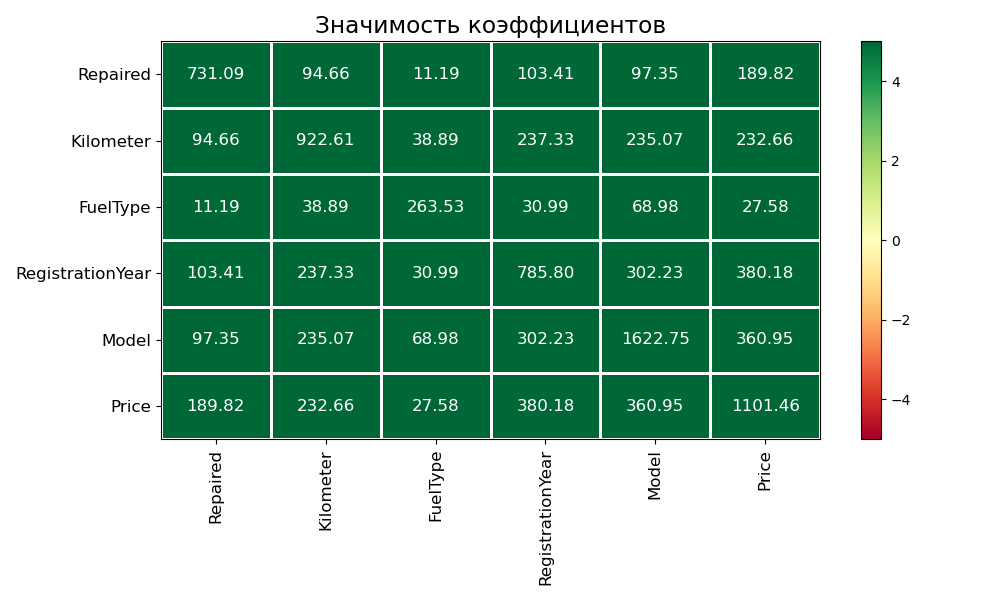

In [213]:
significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Значимость коэффициентов", 
                        usetex=False, fontsize_factor=1.2, figsize=(10, 6))
plt.tight_layout()
plt.show()

Наблюдается абсолютная корреляция между признаками `Brand` и `Model`. С целевым признаком больше коррелирует `Model`.

Также существенная положительная корреляция (> 0.6) есть между `Model` и `VehicleType`/`Gearbox`/`Power`. Это логично, так как у конкретной модели автомобиля эти характеристики, как правило, одинаковые.

Для устранения мультиколлениарности и улучшения эффективности моделей оставим значимый столбец `Model`, удалим столбцы `Brand`, `VehicleType`, `Gearbox`, `Power`:

In [76]:
df = df.drop(['Brand', 'VehicleType', 'Gearbox', 'Power'], axis=1)
print(f'Осталось столбцов: {df.shape[1]}')

Осталось столбцов: 6


Сформируем ProfileReport еще раз:

In [78]:
profile1 = ProfileReport(df, title="Profiling Report")
profile1.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Заполнение пропущенных данных и удаление лишних привело к появлению большого числа строк-полных дубликатов в оставшихся данных. Это нормально, не удаляем, их колличество влияет на предсказание целевого признака.

Значимая корреляция между `RegistrationYear` и целевым признаком `Price` должна положительно сказаться на качестве предсказания моделей.

Признак `FuelType` сильно несбалансирован, так как 98% автомобилей в датасете на бензине. Тем не менее, оставляем признак, корреляция с целевым признаком 0.05. 

**Выводы:**
- исходный датасет содержит 16 столбцов, ~354 тыс. строк, качество данных низкое - много пропусков в столбцах;
- подготовку данных провели на основании результатов отчета ProfileReport;
- удалено 6 столбцов, не влияющих на целевой признак;
- заполнены/удалены пропуски в ячейках;
- выявлены существенные корреляции между признаками (использован коэффициент корреляции $\phi_K$), для устранения мультиколлениарности и улучшения эффективности моделей удалены 4 признака;
- данные подготовлены для моделирования, итоговый датасет содержит 6 столбцов, ~341 тыс. строк, пропусков нет. Числовой целевой признак - `Price`, категориальные признаки - `Model`, `FuelType`, `Repaired`, числовые признаки - `RegistrationYear`, `Kilometer`.

## Обучение моделей

Будем обучать модели RandomForestRegressor, LightGBM, CatBoost

### Подготовка выборок для обучения моделей

Делим тренировочную и тестовую выборки 3:1

In [85]:
features = df.drop(['Price'], axis=1)
target = df['Price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

print(f'Исходный датасет: {df.shape}')
print(f'Проверка: features_train {features_train.shape}, target_train {target_train.shape}')
print(f'Проверка: features_test {features_test.shape}, target_test {target_test.shape}')

Исходный датасет: (341051, 6)
Проверка: features_train (255788, 5), target_train (255788,)
Проверка: features_test (85263, 5), target_test (85263,)


Проверим, что все уникальные значения признака `Model` есть как в обучающей, так и в тестовой выборках: 

In [87]:
models_train = set(features_train['Model'].unique())
models_test = set(features_test['Model'].unique())
num_models_train = len(models_train)
num_models_test = len(models_test)
print(f'''Количество уникальных значений признака "Model"
в обеих выборках одинаковое: {num_models_train == num_models_test}
''')
print(f'''
Уникальные значения признака "Model"
в обеих выборках одинаковые: {models_train == models_test}
''')
print(f'Только в тренировочной выборке есть значения: {models_train - models_test}')
print(f'Только в тестовой выборке есть значения: {models_test - models_train}')

Количество уникальных значений признака "Model"
в обеих выборках одинаковое: True


Уникальные значения признака "Model"
в обеих выборках одинаковые: True

Только в тренировочной выборке есть значения: set()
Только в тестовой выборке есть значения: set()


Создадим переменные с перечнем столбцов категорийного и цифрового типа:

In [89]:
cat_features = ['Model', 'FuelType', 'Repaired']
num_features = ['RegistrationYear', 'Kilometer']

### Модель RandomForestRegressor

Будем использовать порядковое кодирование признака `Model`, так как он имеет большое количество уникальных значений, и OHE кодирование остальных категориальных признаков

In [93]:
# категориальные признаки для OHE RandomForestRegressor
ohe_features_rf = cat_features.copy()
ohe_features_rf.remove('Model')
ohe_features_rf

['FuelType', 'Repaired']

In [94]:
features_train_rf = features_train.copy()
features_test_rf = features_test.copy()

In [95]:
%%time

col_transformer_rf = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_rf
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        ['Model']
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough'
)

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestregressor__n_estimators': [100], # оставили одно значение для ускорения процесса
    'randomforestregressor__max_depth': [15], # оставили одно значение для ускорения процесса
    'randomforestregressor__min_samples_leaf': [2] # оставили одно значение для ускорения процесса
}

gs_rf = GridSearchCV(
    pipline_rf,
    param_grid=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    cv=2, # снизили для ускорения процесса
    n_jobs=-1
)
gs_rf.fit(features_train_rf, target_train)

gs_rf_best_score = gs_rf.best_score_ * -1
gs_rf_best_params = gs_rf.best_params_
print(f'Лучшее значение RMSE на кросс-валидации: {gs_rf_best_score:0.2f}')
print(f'Лучшие гиперпараметры: {gs_rf_best_params}')
print('*' * 50)

Лучшее значение RMSE на кросс-валидации: 2288.74
Лучшие гиперпараметры: {'randomforestregressor__max_depth': 15, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__n_estimators': 100}
**************************************************
CPU times: total: 25.6 s
Wall time: 40.1 s


In [96]:
fit_time_rf = gs_rf.cv_results_['mean_fit_time'][0]
fit_time_rf

12.30037784576416

In [97]:
%%time
predictions_train_rf = gs_rf.predict(features_train_rf)

CPU times: total: 3.58 s
Wall time: 3.66 s


In [98]:
predict_time_rf = gs_rf.cv_results_['mean_score_time'][0]
predict_time_rf

1.7840282917022705

In [99]:
rmse_train_rf = mean_squared_error(target_train, predictions_train_rf, squared=False)
print(f'RMSE модели на обучающей выборке: {rmse_train_rf:0.2f}')

RMSE модели на обучающей выборке: 2147.43


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Модель LightGBM

In [101]:
features_train_lgbm = features_train.copy()
features_test_lgbm = features_test.copy()

LightGBM работает с категориальными признаками напрямую, но эти столбцы должны быть числовыми, поэтому изменим их тип на категорийный, также проведем масштабтрование числовых признаков:

In [103]:
features_train_lgbm[cat_features] = features_train_lgbm[cat_features].astype('category')
features_train_lgbm.info()
print('*' * 50)
features_test_lgbm[cat_features] = features_test_lgbm[cat_features].astype('category')
features_test_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255788 entries, 56974 to 226169
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Model             255788 non-null  category
 1   RegistrationYear  255788 non-null  int64   
 2   FuelType          255788 non-null  category
 3   Kilometer         255788 non-null  int64   
 4   Repaired          255788 non-null  category
dtypes: category(3), int64(2)
memory usage: 6.8 MB
**************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 85263 entries, 212538 to 294575
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Model             85263 non-null  category
 1   RegistrationYear  85263 non-null  int64   
 2   FuelType          85263 non-null  category
 3   Kilometer         85263 non-null  int64   
 4   Repaired          85263 non-null  category
d

In [104]:
scaler = StandardScaler()
scaler.fit(features_train[num_features])

features_train_lgbm[num_features] = scaler.transform(features_train[num_features])
features_test_lgbm[num_features] = scaler.transform(features_test[num_features])

print('Проверка применения масштабирования признаков:')
display(features_train_lgbm.head(3))
display(features_test_lgbm.head(3))

Проверка применения масштабирования признаков:


Model  RegistrationYear FuelType  Kilometer Repaired
56974   transporter          0.201437   petrol   0.577289       no
240954        other         -0.244863   petrol   0.577289       no
298926           c3          0.052671   petrol   0.577289       no

Model  RegistrationYear FuelType  Kilometer Repaired
212538  cooper          0.052671   petrol  -0.767754       no
243278     3er         -0.839931   petrol   0.577289       no
110602   other          0.945272   petrol  -1.574780       no

In [105]:
%%time

model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)


param_grid_lgbm = {
    'n_estimators': [100],
    # 'max_depth': [15],
    # 'num_leaves': [30],
    'learning_rate': [0.05]
}

gs_lgbm = GridSearchCV(
    model_lgbm,
    param_grid=param_grid_lgbm,
    scoring='neg_root_mean_squared_error',
    error_score='raise',
    cv=2,
    n_jobs=-1
)
gs_lgbm.fit(features_train_lgbm, target_train, categorical_feature=cat_features)

gs_lgbm_best_score = gs_lgbm.best_score_ * -1
gs_lgbm_best_params = gs_lgbm.best_params_
print(f'Лучшее значение RMSE на кросс-валидации: {gs_lgbm_best_score:0.2f}')
print(f'Лучшие гиперпараметры: {gs_lgbm_best_params}')
print('*' * 50)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 255788, number of used features: 5
[LightGBM] [Info] Start training from score 4588.166446
Лучшее значение RMSE на кросс-валидации: 2142.71
Лучшие гиперпараметры: {'learning_rate': 0.05, 'n_estimators': 100}
**************************************************
CPU times: total: 2.09 s
Wall time: 3.14 s


In [106]:
fit_time_lgbm = gs_lgbm.cv_results_['mean_fit_time'][0]
fit_time_lgbm

0.6487103700637817

In [107]:
%%time
predictions_train_lgbm = gs_lgbm.predict(features_train_lgbm)

CPU times: total: 2.06 s
Wall time: 524 ms


In [108]:
predict_time_lgbm = gs_lgbm.cv_results_['mean_score_time'][0]
predict_time_lgbm

0.427115797996521

In [109]:
rmse_train_lgbm = mean_squared_error(target_train, predictions_train_lgbm, squared=False)
print(f'RMSE модели на обучающей выборке: {rmse_train_lgbm:0.2f}')

RMSE модели на обучающей выборке: 2104.68


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Модель CatBoost

In [111]:
features_train_cb = features_train.copy()
features_test_cb = features_test.copy()

CatBoost сама применяет различные техники кодирования категориальных признаков, подготавливать их не нужно. Соответственно, проведем только масштабирование числовых признаков:

In [113]:
scaler = StandardScaler()
scaler.fit(features_train[num_features])

features_train_cb[num_features] = scaler.transform(features_train[num_features])
features_test_cb[num_features] = scaler.transform(features_test[num_features])

print('Проверка применения масштабирования признаков:')
display(features_train_cb.head(3))
display(features_test_cb.head(3))

Проверка применения масштабирования признаков:


Model  RegistrationYear FuelType  Kilometer Repaired
56974   transporter          0.201437   petrol   0.577289       no
240954        other         -0.244863   petrol   0.577289       no
298926           c3          0.052671   petrol   0.577289       no

Model  RegistrationYear FuelType  Kilometer Repaired
212538  cooper          0.052671   petrol  -0.767754       no
243278     3er         -0.839931   petrol   0.577289       no
110602   other          0.945272   petrol  -1.574780       no

In [114]:
%%time

model_cb = CatBoostRegressor(random_state=RANDOM_STATE)


param_grid_cb = { 
    # 'iterations': [100],
    # 'depth': [15],
    'learning_rate': [0.1]
}

gs_cb = GridSearchCV(
    model_cb,
    param_grid=param_grid_cb,
    scoring='neg_root_mean_squared_error',
    error_score='raise',
    cv=2,
    n_jobs=-1
)
gs_cb.fit(features_train_cb, target_train, cat_features=cat_features, verbose=False)

gs_cb_best_score = gs_cb.best_score_ * -1
gs_cb_best_params = gs_cb.best_params_
print(f'Лучшее значение RMSE на кросс-валидации: {gs_cb_best_score:0.2f}')
print(f'Лучшие гиперпараметры: {gs_cb_best_params}')
print('*' * 50)

Лучшее значение RMSE на кросс-валидации: 2231.79
Лучшие гиперпараметры: {'learning_rate': 0.1}
**************************************************
CPU times: total: 3min 47s
Wall time: 2min 27s


In [115]:
fit_time_cb = gs_cb.cv_results_['mean_fit_time'][0]
fit_time_cb

67.77510976791382

In [116]:
%%time
predictions_train_cb = gs_cb.predict(features_train_cb)

CPU times: total: 1.95 s
Wall time: 749 ms


In [117]:
predict_time_cb = gs_cb.cv_results_['mean_score_time'][0]
predict_time_cb

0.46958744525909424

In [118]:
rmse_train_cb = mean_squared_error(target_train, predictions_train_cb, squared=False)
print(f'RMSE модели на обучающей выборке: {rmse_train_cb:0.2f}')

RMSE модели на обучающей выборке: 2202.75


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Выводы:**
- данные разбиты на обучающую и тестовую выборки в соотношении 3:1;
- для каждой модели потребовалась индивидуальная подготовка данных;
- подбор гиперпараметров и кросс-валидация осуществлены с помощью GridSearchCV;
- три модели обучены, предсказания получены, время обучения и предсказания рассчитано, RMSE на обучающей выборке рассчитан.

## Анализ моделей

### Выбор лучшей модели

In [122]:
result = pd.DataFrame(
    [[rmse_train_rf, fit_time_rf, predict_time_rf],
    [rmse_train_lgbm, fit_time_lgbm, predict_time_lgbm],
    [rmse_train_cb, fit_time_cb, predict_time_cb]],
    columns=['RMSE', 'Fit_time', 'Predict_time'],
    index=['RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor'],
)

Выберем лучшую модель по совокупности показателей по следующей формуле (чем результат получится меньше, тем лучше):

$$
Score = 0.5 * (RMSE / RMSE_{max}) + 0.3 * (FitTime / FitTime_{max}) + 0.2 * (PredictTime / PredictTime_{max})
$$

In [124]:
result['Score'] = 0.5 * result['RMSE'] / result['RMSE'].max() + \
0.3 * result['Fit_time'] / result['Fit_time'].max() + \
0.2 * result['Predict_time'] / result['Predict_time'].max()

In [125]:
result

RMSE   Fit_time  Predict_time     Score
RandomForestRegressor  2147.426695  12.300378      1.784028  0.741890
LGBMRegressor          2104.680430   0.648710      0.427116  0.528494
CatBoostRegressor      2202.745951  67.775110      0.469587  0.852643

**Вывод:** 
- значение метрики RMSE у моделей меньше 2500;
- исходя из важности критериев для заказчика лучший совокупный результат показала модель LGBMRegressor.

### Проверка качества лучшей модели на тестовой выборке

In [128]:
predictions_test_lgbm = gs_lgbm.predict(features_test_lgbm)
rmse_test_lgbm = mean_squared_error(target_test, predictions_test_lgbm, squared=False)
print(f'RMSE модели на тестовой выборке: {rmse_test_lgbm:0.2f}')

RMSE модели на тестовой выборке: 2136.58


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


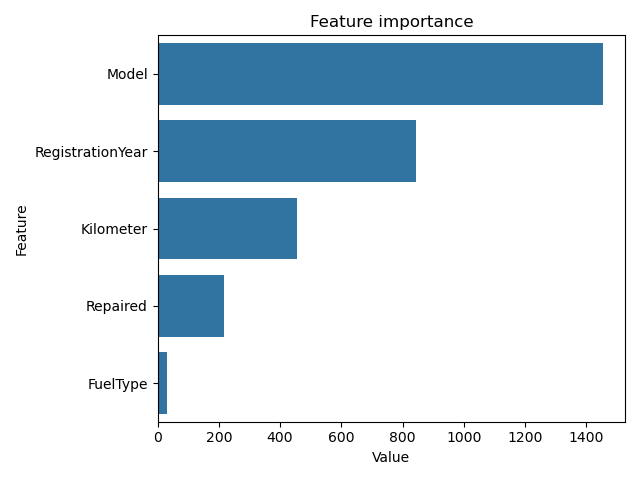

In [129]:
feature_importance = gs_lgbm.best_estimator_.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

**Вывод:** качество LGBMRegressor на тестовой выборке сравнимо с результатом на обучающей.

## Общий вывод:

1. Подготовка данных:
- исходный датасет содержит 16 столбцов, ~354 тыс. строк, качество данных низкое - много пропусков;
- подготовку данных провели на основании результатов отчета ProfileReport;
- удалено 6 столбцов, не влияющих на целевой признак;
- заполнены/удалены пропуски в ячейках;
- выявлены существенные корреляции между признаками (использован коэффициент корреляции $\phi_K$), для устранения мультиколлениарности и улучшения эффективности моделей удалены еще 4 признака;
- данные подготовлены для моделирования, итоговый датасет содержит 6 столбцов, ~341 тыс. строк, пропусков нет. Числовой целевой признак - `Price`, категориальные признаки - `Model`, `FuelType`, `Repaired`, числовые признаки - `RegistrationYear`, `Kilometer`.

2. Обучение моделей:
- данные разбиты на обучающую и тестовую выборки в соотношении 3:1;
- для каждой модели потребовалась индивидуальная подготовка данных;
- подбор гиперпараметров и кросс-валидация осуществлены с помощью GridSearchCV;
- модели RandomForestRegressor, LightGBM, CatBoost обучены, предсказания получены, время обучения и предсказания рассчитано, RMSE на обучающей выборке рассчитан.

3. Анализ моделей:
- значение метрики RMSE на обучающей выборке у моделей меньше 2500;
- исходя из важности критериев для заказчика лучший результат на обучающей выборке показала модель LGBMRegressor;
- качество LGBMRegressor на тестовой выборке сравнимо с результатом на обучающей.